# Fast Fourier Transform

**Jack Haek**

---

## What is the Fast Fourier Transform Algorithm

The Fast Fourier Transform Algorithm (FFT) is possibly one of the most important and elegant algorithms published in the 20th century. The effects of this algorithm stretch to many industries including, but not limited to medical imaging, telecommunications, electromagnetic wave and quantum mechanics, as well as nearly anything to do with signal processing. For the demo today, we will see the algorithm identify what composition of sin waves is used to create a more complex wave.

**Discrete Fourier Transform (DFT)**

With regards to real world applications, the Fourier Transform is not always super helpful as functional forms of signals are not all that common. Thus, the Discrete Fourier Transform (DFT) was roughly derived from the FT.


**FT**
$$
f(k) = \int_{-\infty}^{\infty}f(x)e^{-2\pi ikx}dx
$$

**DFT**
$$
f_k=\sum_{0}^{N-1}x_ne^{\frac{-2\pi ikn}{N}}
$$

In DFT, $x_n$ refers to an element of our discrete signal. This is a vector. $F_k$ is an element of our transformed signal. $n$ and $k$ are indexes corresponding to the original and transformed signal vectors. To make this easier to see and for easier notation later, we are going to introduce a new term. 

$$
\omega_{kn} = e^{\frac{-2\pi ikn}{N}}
$$

Note that with the two coordinate values for $\omega$ we can now think of this as a two dimensional matrix. This is what our new equation looks like:

**DFT**
$$
f_k=\sum_{0}^{N-1}\omega_{kn}x_n
$$

To show the vectors and matrices

$$
f_k \rightarrow \begin{bmatrix}
f_0
\\
f_1
\\
...
\\ 
f_{k-1}
\end{bmatrix}
x_n \rightarrow \begin{bmatrix}
x_0
\\
x_1
\\
...
\\ 
x_{N-1}
\end{bmatrix}
\omega_{kn} \rightarrow\begin{bmatrix}
\omega_{0,0} & \omega_{0,1} & ... & \omega_{0,N-1} \\ 
\omega_{1,0} & \omega_{1,1} &  & ... \\
... &  &  & ... \\ 
\omega_{k-1,0} & ...  & ... & \omega_{k-1,N-1} 
\end{bmatrix}
$$

Filling in the equation:

$$
\begin{bmatrix}
f_0
\\
f_1
\\
...
\\ 
f_{k-1}
\end{bmatrix} = \begin{bmatrix}
\omega_{0,0} & \omega_{0,1} & ... & \omega_{0,N-1} \\ 
\omega_{1,0} & \omega_{1,1} &  & ... \\
... &  &  & ... \\ 
\omega_{k-1,0} & ...  & ... & \omega_{k-1,N-1} 
\end{bmatrix}\begin{bmatrix}
x_0
\\
x_1
\\
...
\\ 
x_{N-1}
\end{bmatrix}
$$

While it is great that we can represent the equation in matrix form as it makes it easier to map to GPU's for parallelization. Currently, 2 for loops are still needed. This gives $O(n^2)$ for the computational time complexity. To put this into context, that would mean that a 4 minute song would have the following number of computations:

$$
(4min * \frac{60sec}{1min} * \frac{44100}{1sec})^2 \approx 1.12 * 10^{14}
$$

**Fast Fourier Transform (FFT)**

Fast Fourier Transform describes an efficient algorithm for computing DFT. The main concept of FFT is instead of using the matrices described above, we will use 3 sparse matrices where one is a permutation matrix. This takes advantage of symmetrical patters that emerge and brings the computational time complexity down to $O(nlog(n))$!

**Sparse Matrix**
$$
\omega_N = \begin{bmatrix}
I_{N/2} & D_{N/2} \\ 
I_{N/2} & -D_{N/2}
\end{bmatrix}\begin{bmatrix}
\omega_{N/2} & 0 \\ 
0 & \omega_{N/2}
\end{bmatrix}(P)
$$

**Permutation Matrix**
$$
P_x = \begin{bmatrix}
x_{even} \\
x_{odd}
\end{bmatrix}
$$


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import time
import warnings
warnings.filterwarnings("ignore")
from scipy.fft import fft, fftfreq, fftshift

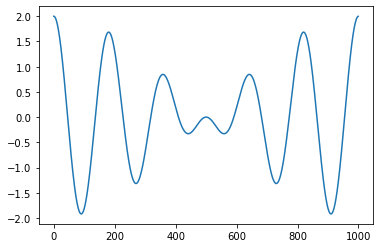

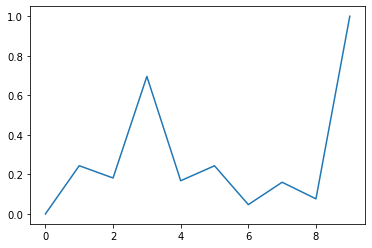

In [18]:
RES = 1000
DUR = 1

def createWave(duration, resolution, frequency):
    t = np.arange(0, duration, duration/resolution)
    return pow(np.e, 2 * np.pi * 1j * frequency * t)

def split(points):
    idx = 0
    p_e = []
    p_o = []
    for point in points:
        if idx % 2 == 0:
            # Even index
            p_e.append(point)
        else:
            # Odd index
            p_o.append(point)
        idx += 1
    return (p_e, p_o)


def my_FFT(P):
    n = len(P)
    if n == 1:
        return P
    omega = pow(np.e, (2*np.pi*1j)/n)
    pe, po = split(P)
    ye, yo = my_FFT(pe), my_FFT(po)
    y = [0] * n
    for j in range(n//2):
        y[j] = ye[j]+(pow(omega, j)*yo[j])
        y[j + n//2] = ye[j] - (pow(omega, j)*yo[j])
    return y                      

complex_wave = createWave(DUR, RES, 3) + createWave(DUR, RES, 9)
plt.plot(complex_wave)
plt.show()

plt.plot(np.abs(my_FFT(complex_wave)[0:10])/max(np.abs(my_FFT(complex_wave)[0:10])))
plt.show()


In [6]:
# Testing

test_cases = [50000, 100000, 150000, 200000, 250000, 300000, 350000, 400000]
custom_avg_times = []

for index, test in enumerate(test_cases):
    RES = test
    DUR = 1
    complex_wave = createWave(DUR, RES, 2) + createWave(DUR, RES, 4)
    individual_times = []
    for i in range(5):
        print(f"Starting test {i+1} for test case {index + 1}")
        start = time.time()
        freq_wave = my_FFT(complex_wave)
        end = time.time()
        individual_times.append(end-start)
    print("\n")
    custom_avg_times.append(np.average(individual_times))

Starting test 1 for test case 1
Starting test 2 for test case 1
Starting test 3 for test case 1
Starting test 4 for test case 1
Starting test 5 for test case 1


Starting test 1 for test case 2
Starting test 2 for test case 2
Starting test 3 for test case 2
Starting test 4 for test case 2
Starting test 5 for test case 2


Starting test 1 for test case 3
Starting test 2 for test case 3
Starting test 3 for test case 3
Starting test 4 for test case 3
Starting test 5 for test case 3


Starting test 1 for test case 4
Starting test 2 for test case 4
Starting test 3 for test case 4
Starting test 4 for test case 4
Starting test 5 for test case 4


Starting test 1 for test case 5
Starting test 2 for test case 5
Starting test 3 for test case 5
Starting test 4 for test case 5
Starting test 5 for test case 5


Starting test 1 for test case 6
Starting test 2 for test case 6
Starting test 3 for test case 6
Starting test 4 for test case 6
Starting test 5 for test case 6


Starting test 1 for test cas

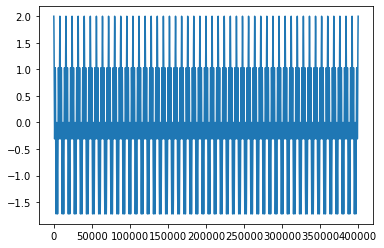

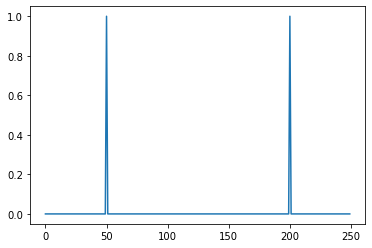

In [7]:
def scipy_fft(wave_in, N, T):
    yf = fft(wave_in)
    xf = fftfreq(N, T)
    xf = fftshift(xf)
    yplot = fftshift(yf)
    half = len(xf)//2
    return (xf[half:half+250], 1.0/N * np.abs(yplot[half:half+250]))

complex_wave = createWave(DUR, RES, 50) + createWave(DUR, RES, 200)
plt.plot(complex_wave)
plt.show()
freq = scipy_fft(complex_wave, RES, DUR/RES)

plt.plot(freq[0], freq[1])
plt.show()

In [19]:
scipy_avg_times = []

for index, test in enumerate(test_cases):
    RES = test
    DUR = 1
    complex_wave =  createWave(DUR, RES, 2) + createWave(DUR, RES, 4)
    individual_times = []
    for i in range(5):
        print(f"Starting test {i+1} for test case {index + 1}")
        start = time.time()
        freq = scipy_fft(complex_wave, RES, DUR/RES)
        end = time.time()
        individual_times.append(end-start)
    print("\n")
    scipy_avg_times.append(np.average(individual_times))

Starting test 1 for test case 1
Starting test 2 for test case 1
Starting test 3 for test case 1
Starting test 4 for test case 1
Starting test 5 for test case 1


Starting test 1 for test case 2
Starting test 2 for test case 2
Starting test 3 for test case 2
Starting test 4 for test case 2
Starting test 5 for test case 2


Starting test 1 for test case 3
Starting test 2 for test case 3
Starting test 3 for test case 3
Starting test 4 for test case 3
Starting test 5 for test case 3


Starting test 1 for test case 4
Starting test 2 for test case 4
Starting test 3 for test case 4
Starting test 4 for test case 4
Starting test 5 for test case 4


Starting test 1 for test case 5
Starting test 2 for test case 5
Starting test 3 for test case 5
Starting test 4 for test case 5
Starting test 5 for test case 5


Starting test 1 for test case 6
Starting test 2 for test case 6
Starting test 3 for test case 6
Starting test 4 for test case 6
Starting test 5 for test case 6


Starting test 1 for test cas

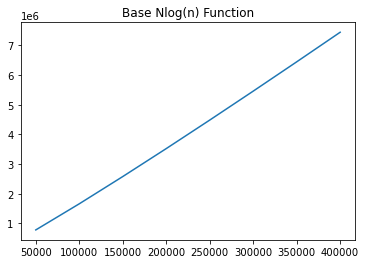

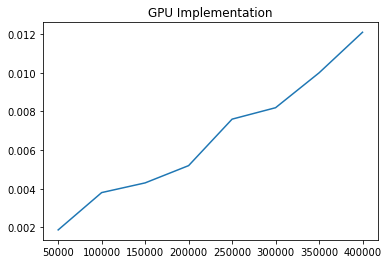

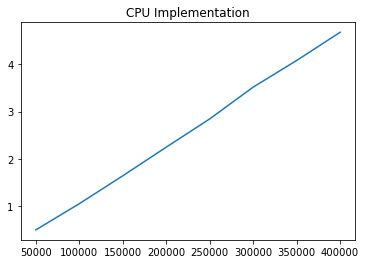

In [20]:
plt.plot(test_cases, test_cases*np.log2(test_cases)-15)
plt.title("Base Nlog(n) Function")
plt.show()
plt.plot(test_cases, scipy_avg_times)
plt.title("GPU Implementation")
plt.show()
plt.plot(test_cases, custom_avg_times)
plt.title("CPU Implementation")
plt.show()

## Resources

1. [The Fast Fourier Transform FFT](https://medium.com/swlh/the-fast-fourier-transform-fft-5e96cf637c38#:~:text=The%20FFT%20is%20an%20efficient,the%20Permutation%20matrix%2C%20used%20above.) written by Shawhin Talebi

2. [But what is the Fourier Transform? A visual Introduction](https://www.youtube.com/watch?v=spUNpyF58BY&t=953s) by 3Blue1Brown

3. [The Fast Fourier Transform (FFT): Most Ingenious Algorithm Ever?](https://www.youtube.com/watch?v=h7apO7q16V0) by Reducible